# Flower Recognition - Data and Model Analysis

Import all dependencies and establish the device used (CPU or CUDA)

In [1]:
#Standart Numpy and Pandas
import numpy as np
import pandas as pd

#For system management and file naming
import os
#import random
#from operator import itemgetter
import copy
import time
from datetime import datetime

#Torch libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F

#Matplotlib and seaborn for plots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns

#Sklearn for confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

#For images
from PIL import Image

import glob

#To see the progress in for loops
from tqdm import tqdm

#To save datastructures
import pickle

#Tensorboard is also available for an alternative view of the graphs
from torch.utils.tensorboard import SummaryWriter

#Look for cuda and use it as device, if not use cpu
device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device being used : " + str(device))

#Sanity Check - Torch's version
print(torch.__version__)

Device being used : cuda:0
1.11.0+cu113


Define the Paths and Categories(labels)

In [13]:
#Define Paths
path_dataset = "flowers"
path_split = "tvt_flowers"
path_models = "models"
path_plots = "plots"

path_train = os.path.join(path_split, "train")
path_train_normalized = os.path.join(path_split, "train_normalized")
path_train_aug = os.path.join(path_split, "train_aug")
path_train_less_aug = os.path.join(path_split, "train_less_aug")
path_train_simple_aug = os.path.join(path_split, "train_simple_aug")
path_train_one_aug = os.path.join(path_split, "train_one_aug")

path_test = os.path.join(path_split, "test")
path_val = os.path.join(path_split, "val")

#Create missing paths
paths_to_create = [path_plots, path_models]

for path in paths_to_create:
    try:
        os.makedirs(path)
    except:
        print("Directory " + path + " already exists")

categories=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Directory plots already exists
Directory models already exists


### Data Augmentation

How is the data distributed among the 5 categories?

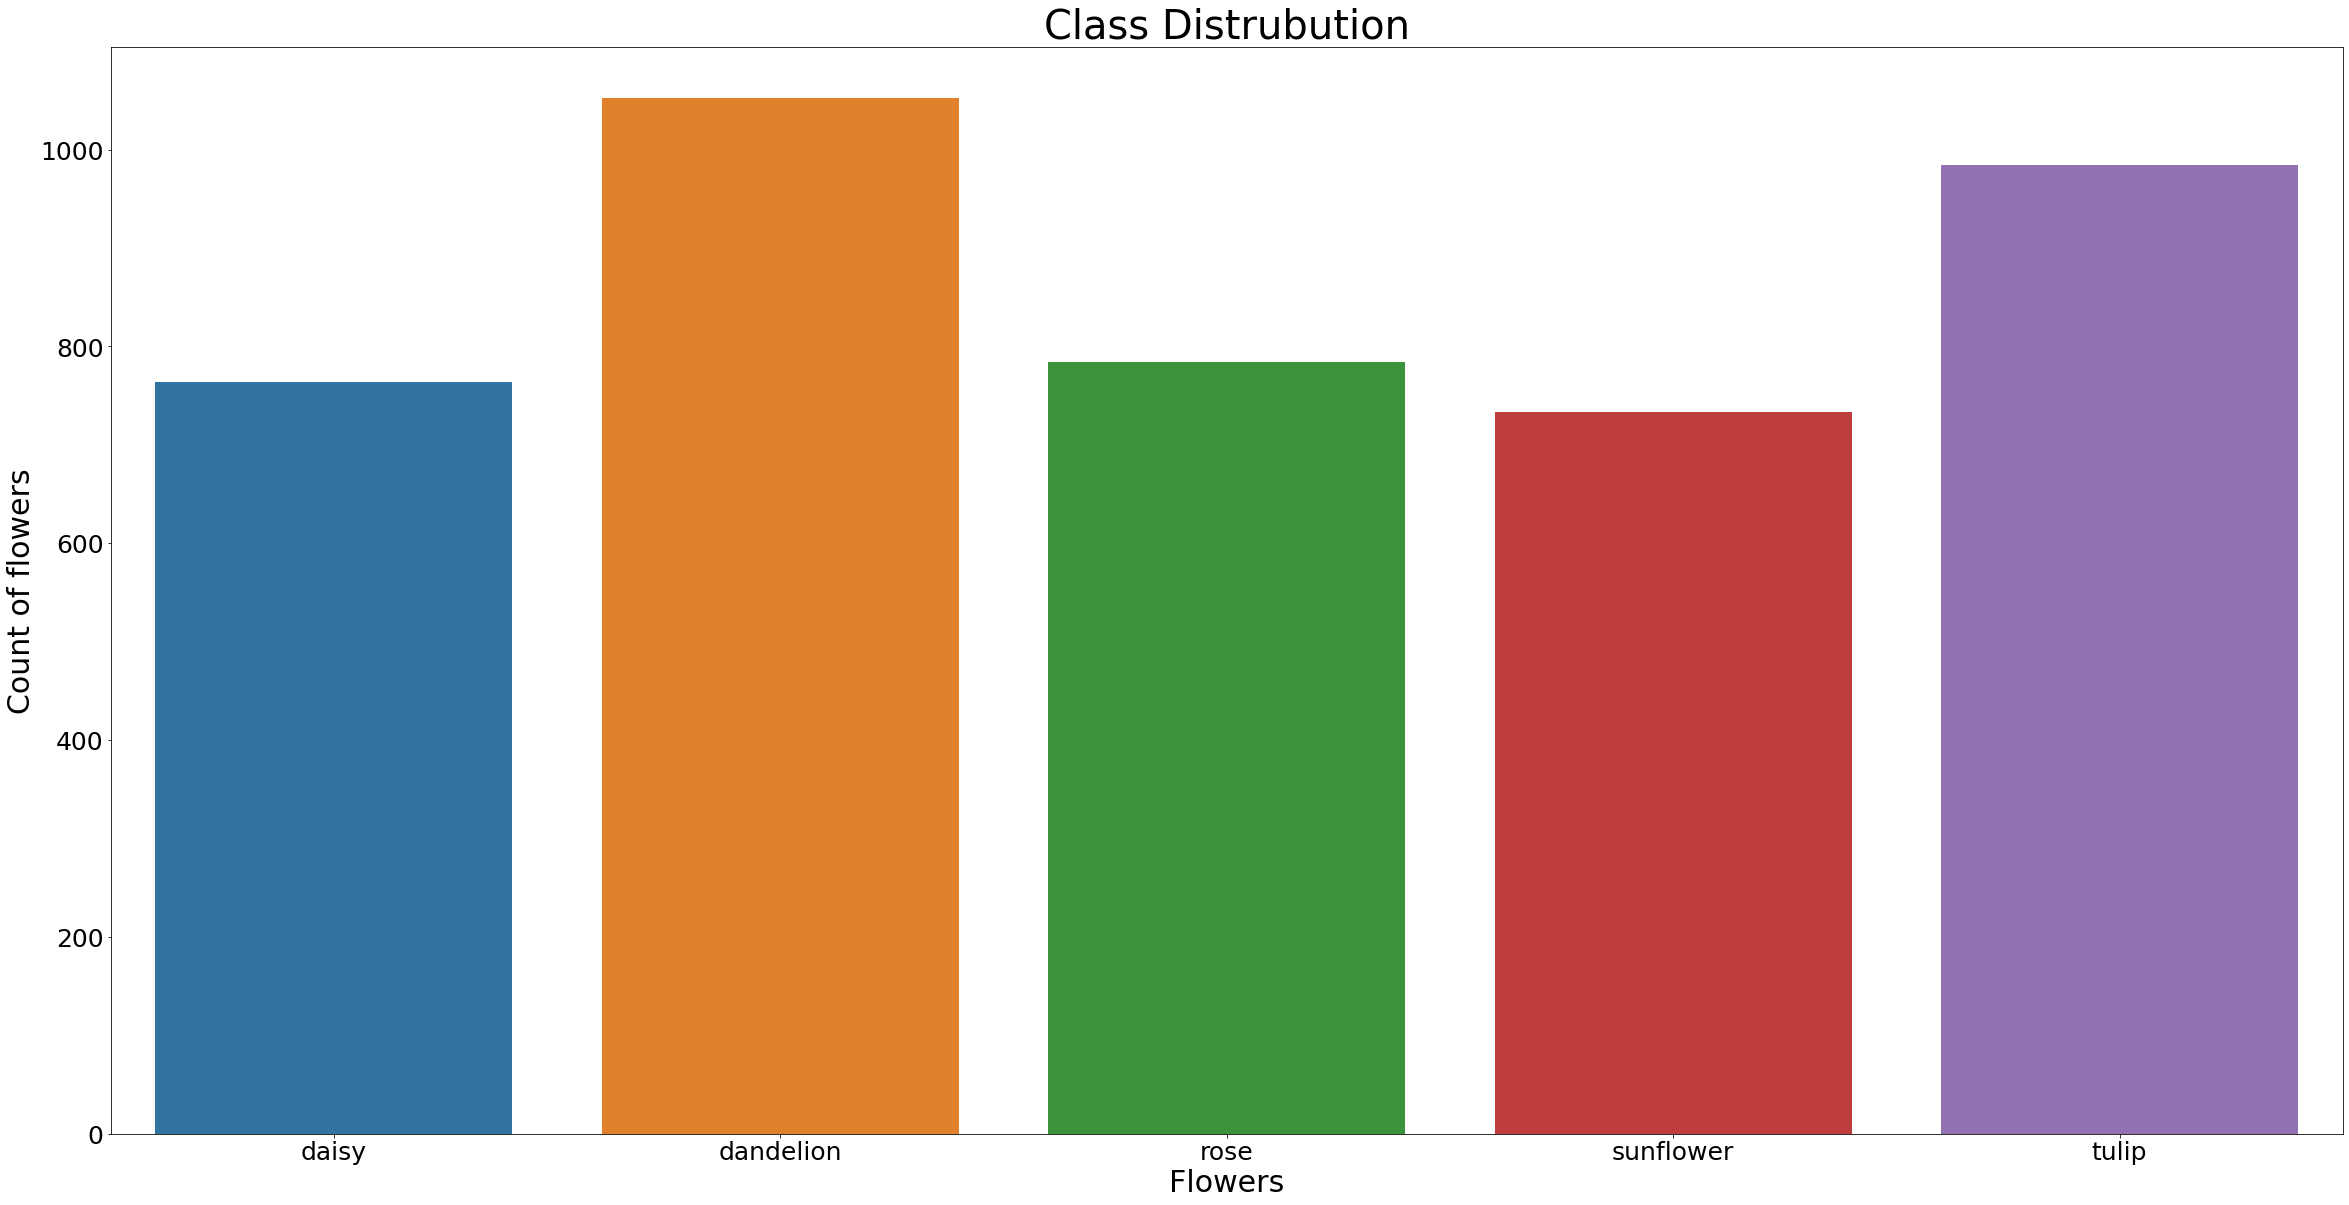

In [3]:
#Initialize a dic to put the count of samples in each class
dic = {}

#Do the counting
for classes in categories:
      dic[classes] = [len([os.path.join(path_dataset, classes, filename) for filename in os.listdir(os.path.join(path_dataset, classes))])]

#Use Pandas to put the data in a format for sns
samplesize = pd.DataFrame.from_dict(dic)

#Resize the figure
figure_size = plt.rcParams['figure.figsize']
figure_size[0] = 40
figure_size[1] = 20
plt.rcParams['figure.figsize'] = figure_size

#Barplot
sns.barplot(data=samplesize)

#Image Labelling
index = np.arange(len(categories))

plt.xlabel('Flowers', fontsize=30)
plt.ylabel('Count of flowers', fontsize=30)
plt.xticks(index, categories, fontsize=25)
plt.yticks(fontsize=25)
plt.title('Class Distrubution', fontsize=40)
plt.show()

It is always good to know with what kind of data we are dealing with. Let's look at two flowers from our data.

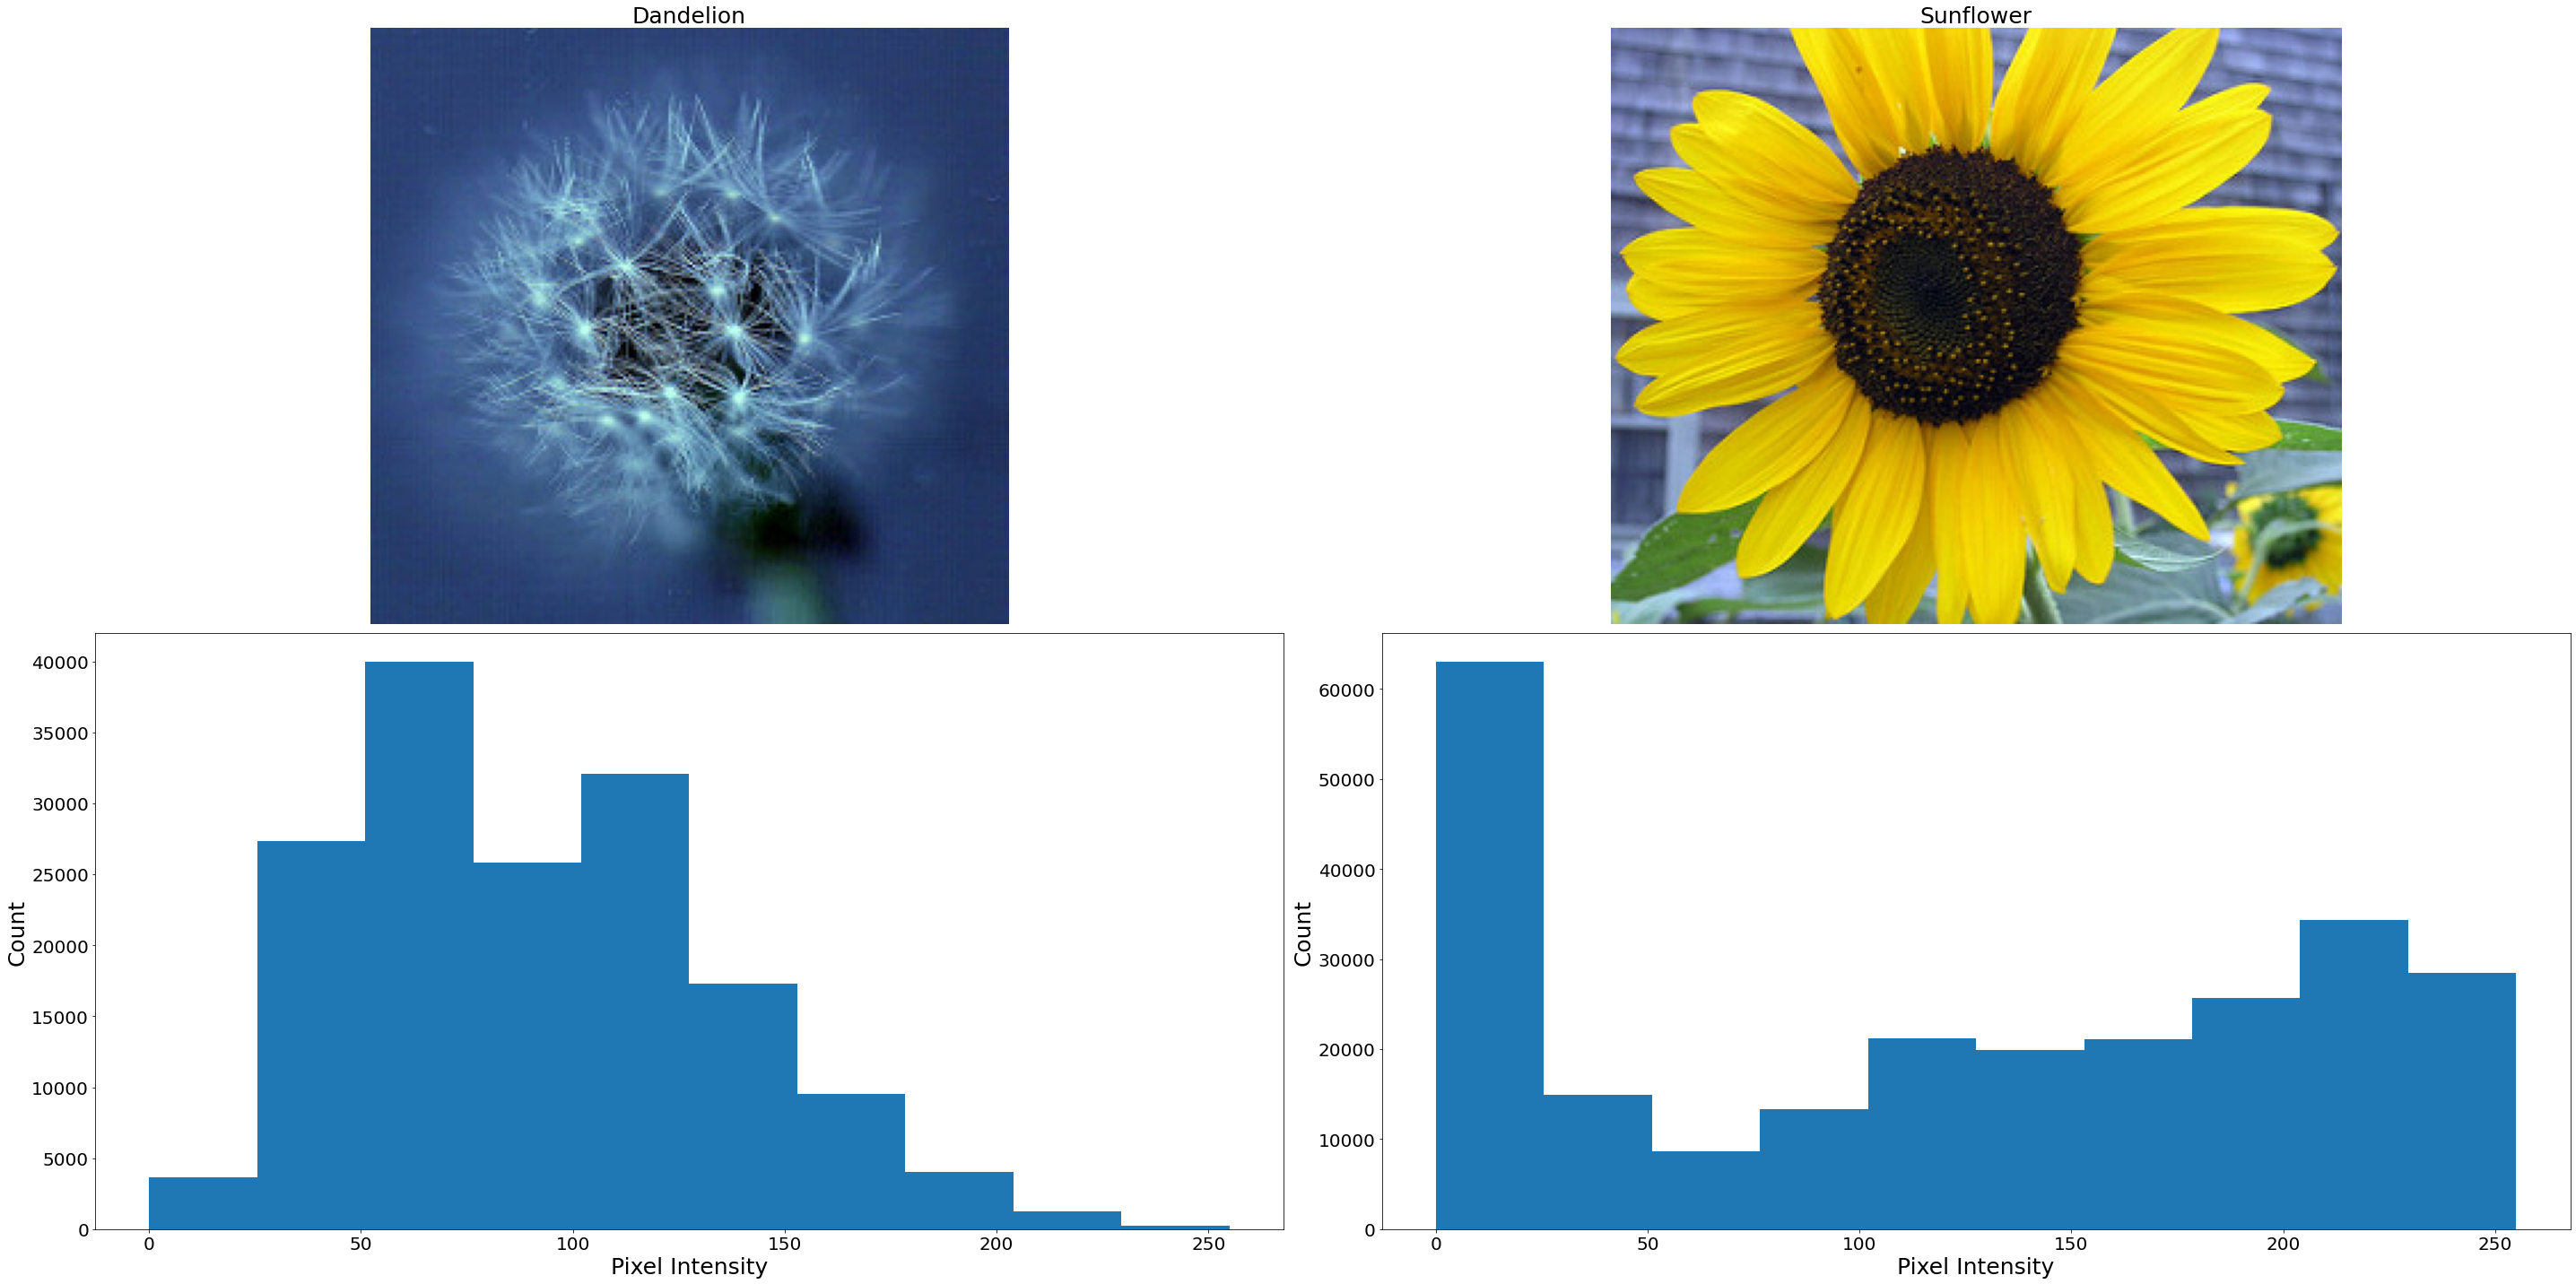

In [4]:
#Fetch the two flowers
flower1_path = os.path.join(path_dataset, "dandelion", "14829055_2a2e646a8f_m.jpg")
flower2_path = os.path.join(path_dataset, "sunflower", "44079668_34dfee3da1_n.jpg")

#Read the two flowers
flower1 = mpimg.imread(flower1_path)
flower2 =  mpimg.imread(flower2_path)

#Plot the flowers
fig, axarr = plt.subplots(2,2)

axarr[0,0].imshow(flower1)
axarr[0,0].axis('off')
axarr[0,0].set_title('Dandelion', fontsize=25)

axarr[0,1].imshow(flower2)
axarr[0,1].axis('off')
axarr[0,1].set_title('Sunflower', fontsize=25)

#Plot the flowers pixel intensity
axarr[1,0].hist(flower1.flatten(),bins = 10)
axarr[1,0].set_xlabel('Pixel Intensity', fontsize=25)
axarr[1,0].set_ylabel('Count', fontsize=25)
axarr[1,0].tick_params(axis='x', labelsize=20)
axarr[1,0].tick_params(axis='y', labelsize=20)

axarr[1,1].hist(flower2.flatten(),bins = 10)
axarr[1,1].set_xlabel('Pixel Intensity', fontsize=25)
axarr[1,1].set_ylabel('Count', fontsize=25)
axarr[1,1].tick_params(axis='x', labelsize=20)
axarr[1,1].tick_params(axis='y', labelsize=20)

fig.tight_layout()

#Save the image
plt.savefig(os.path.join(path_plots,"two_flowers"))

The pixel distribution is really different and also, the images have different sizes. Therefore, normalization and resizing is needed.
For normalization, we go through every image and find the mean and std of the dataset.

Note: This block can be skipped by uncommenting the next block and only running that one. This way, all the computations are skipped.

In [3]:
#Height and Width Image Dimension
image_dimension = 220
#Import the dataset and resize
transformation_Resize_Tensor = transforms.Compose([transforms.Resize((image_dimension,image_dimension)), transforms.ToTensor()])
data = ImageFolder(path_dataset,transformation_Resize_Tensor)

#Take the labels out of the dataset, so only the images remain
data_without_labels = []
for i in tqdm(range(len(data))):
    aux, _ = data[i]
    data_without_labels.append(aux)

#Transform into a tensor
data_without_labels = torch.stack(data_without_labels)
print("Data shape : " + str(data_without_labels.shape))

#Calculate the mean and the std for each channel
channel_means = data_without_labels.mean(axis=[0,2,3])
channel_std = data_without_labels.std(axis=[0,2,3])
print("Channel means : " + str(channel_means))
print("Channel standart deviations : " + str(channel_std))

100%|██████████| 4317/4317 [00:39<00:00, 108.05it/s]


Data shape : torch.Size([4317, 3, 220, 220])
Channel means : tensor([0.4590, 0.4201, 0.3005])
Channel standart deviations : tensor([0.2940, 0.2635, 0.2863])


In [14]:
#channel_means = torch.Tensor([0.4590, 0.4201, 0.3005])
#channel_std = torch.Tensor([0.2940, 0.2635, 0.2863])

Let's see the impact of the normalization in two pictures

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


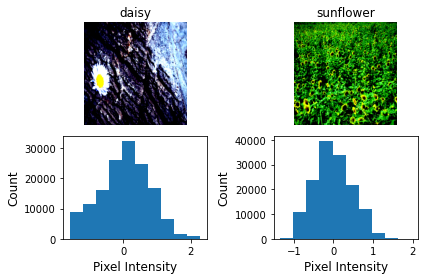

In [15]:
#Define a simple transformation
transformations = {}
#Raw images resized
transformations['raw'] = transforms.Compose([
                                                transforms.Resize((220, 220)),
                                                transforms.ToTensor(), 
                                                ])

#Resize and Normalization given the calculated means and stds
transformations['normalized'] = transforms.Compose([
                                                transforms.Resize((220, 220)),
                                                transforms.ToTensor(), 
                                                transforms.Normalize((channel_means[0].item(), channel_means[1].item(), channel_means[2].item()), 
                                                                    (channel_std[0].item(), channel_std[1].item(), channel_std[2].item()))])

#Import the dataset into a pytorch structure
dataset = {}
dataset['experiment'] = ImageFolder(path_dataset, transform=transformations['normalized'])

#Choose two images
img1, label1 = dataset['experiment'][596]
img2, label2 = dataset['experiment'][2989]

#To display them the channels need to be in the last dimensiom, but pytorch puts them before the pixels, so we perform permutation
img1 = np.array(img1).transpose(1,2,0)
img2 = np.array(img2).transpose(1,2,0)

#Plotting of the images
fig, axarr = plt.subplots(2,2)

axarr[0,0].imshow(img1)
axarr[0,0].axis('off')
axarr[0,0].set_title(categories[label1], fontsize=12)

axarr[0,1].imshow(img2)
axarr[0,1].axis('off')
axarr[0,1].set_title(categories[label2], fontsize=12)

#Histograms of the pixel intensity
axarr[1,0].hist(img1.ravel(),bins = 10)
axarr[1,0].set_xlabel('Pixel Intensity', fontsize=12)
axarr[1,0].set_ylabel('Count', fontsize=12)
axarr[1,0].tick_params(axis='x', labelsize=10)
axarr[1,0].tick_params(axis='y', labelsize=10)

axarr[1,1].hist(img2.ravel(),bins = 10)
axarr[1,1].set_xlabel('Pixel Intensity', fontsize=12)
axarr[1,1].set_ylabel('Count', fontsize=12)
axarr[1,1].tick_params(axis='x', labelsize=10)
axarr[1,1].tick_params(axis='y', labelsize=10)

fig.tight_layout()

#Save the image
plt.savefig(os.path.join(path_plots,"two_flowers_normalized"))

Dataset only has 4317 samples. That is not a big number of samples. We perform data augmentation using the three prebuilt pytorch transformations corresponding to the dataset CIFAR10, IMAGENET, and SVHN plus three more transformations using the 'torchvision.transformations' module. The transformations used are displayed below.

In the real training the transformations below are also normalized, but in order to properly show the type of transformations implemented the normalization is removed here.

In [16]:
#Define the three transformations
transformations['CIFAR10'] = transforms.Compose([
                                                transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                                transforms.Resize((220, 220)),
                                                transforms.ToTensor(), 
                                                ])


transformations['IMAGENET'] = transforms.Compose([
                                                transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
                                                transforms.Resize((220, 220)),
                                                transforms.ToTensor(), 
                                                ])

transformations['SVHN'] = transforms.Compose([
                                                transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
                                                transforms.Resize((220, 220)),
                                                transforms.ToTensor(), 
                                                ])

transformations['Flip_Rot_Aff'] = transforms.Compose([
                                 transforms.Resize((220, 220)),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomRotation(15),
                                 transforms.RandomAffine(translate=(0.08,0.1), degrees=15),
                                 transforms.ToTensor(),
                                 ])

transformations['Random_Erasing'] = transforms.Compose([
                                 transforms.Resize((220, 220)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(10),
                                 transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                 transforms.ToTensor(),
                                 transforms.RandomErasing(p=1,inplace=True, scale=(0.01, 0.23)),
                                 ])

transformations['Color_Jitter'] = transforms.Compose([
                                 transforms.Resize((220, 220)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(5),
                                 transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                 transforms.ToTensor(),
                                 transforms.ColorJitter(brightness=0.2,contrast=0.2, saturation=0.2),
                                 ])

Apply transformations to training data

In [24]:
#Apply the three diferent trasnformations to the dataset and store them
training_data_path = os.path.join(path_split,"train")
validation_data_path = os.path.join(path_split,"val")
testing_data_path =os.path.join(path_split,"test")

dataset['raw'] = ImageFolder(training_data_path, transform=transformations['raw'])
dataset['normalized'] = ImageFolder(training_data_path, transform=transformations['normalized'])
dataset['CIFAR10'] = ImageFolder(training_data_path, transform=transformations['CIFAR10'])
dataset['IMAGENET'] = ImageFolder(training_data_path, transform=transformations['IMAGENET'])
dataset['SVHN'] = ImageFolder(training_data_path, transform=transformations['SVHN'])
dataset['Flip_Rot_Aff'] = ImageFolder(training_data_path, transform=transformations['Flip_Rot_Aff'])
dataset['Random_Erasing'] = ImageFolder(training_data_path, transform=transformations['Random_Erasing'])
dataset['Color_Jitter'] = ImageFolder(training_data_path, transform=transformations['Color_Jitter'])

Look at an image from each transformation (each time this cell is run a different trasnformation is applied to the same image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


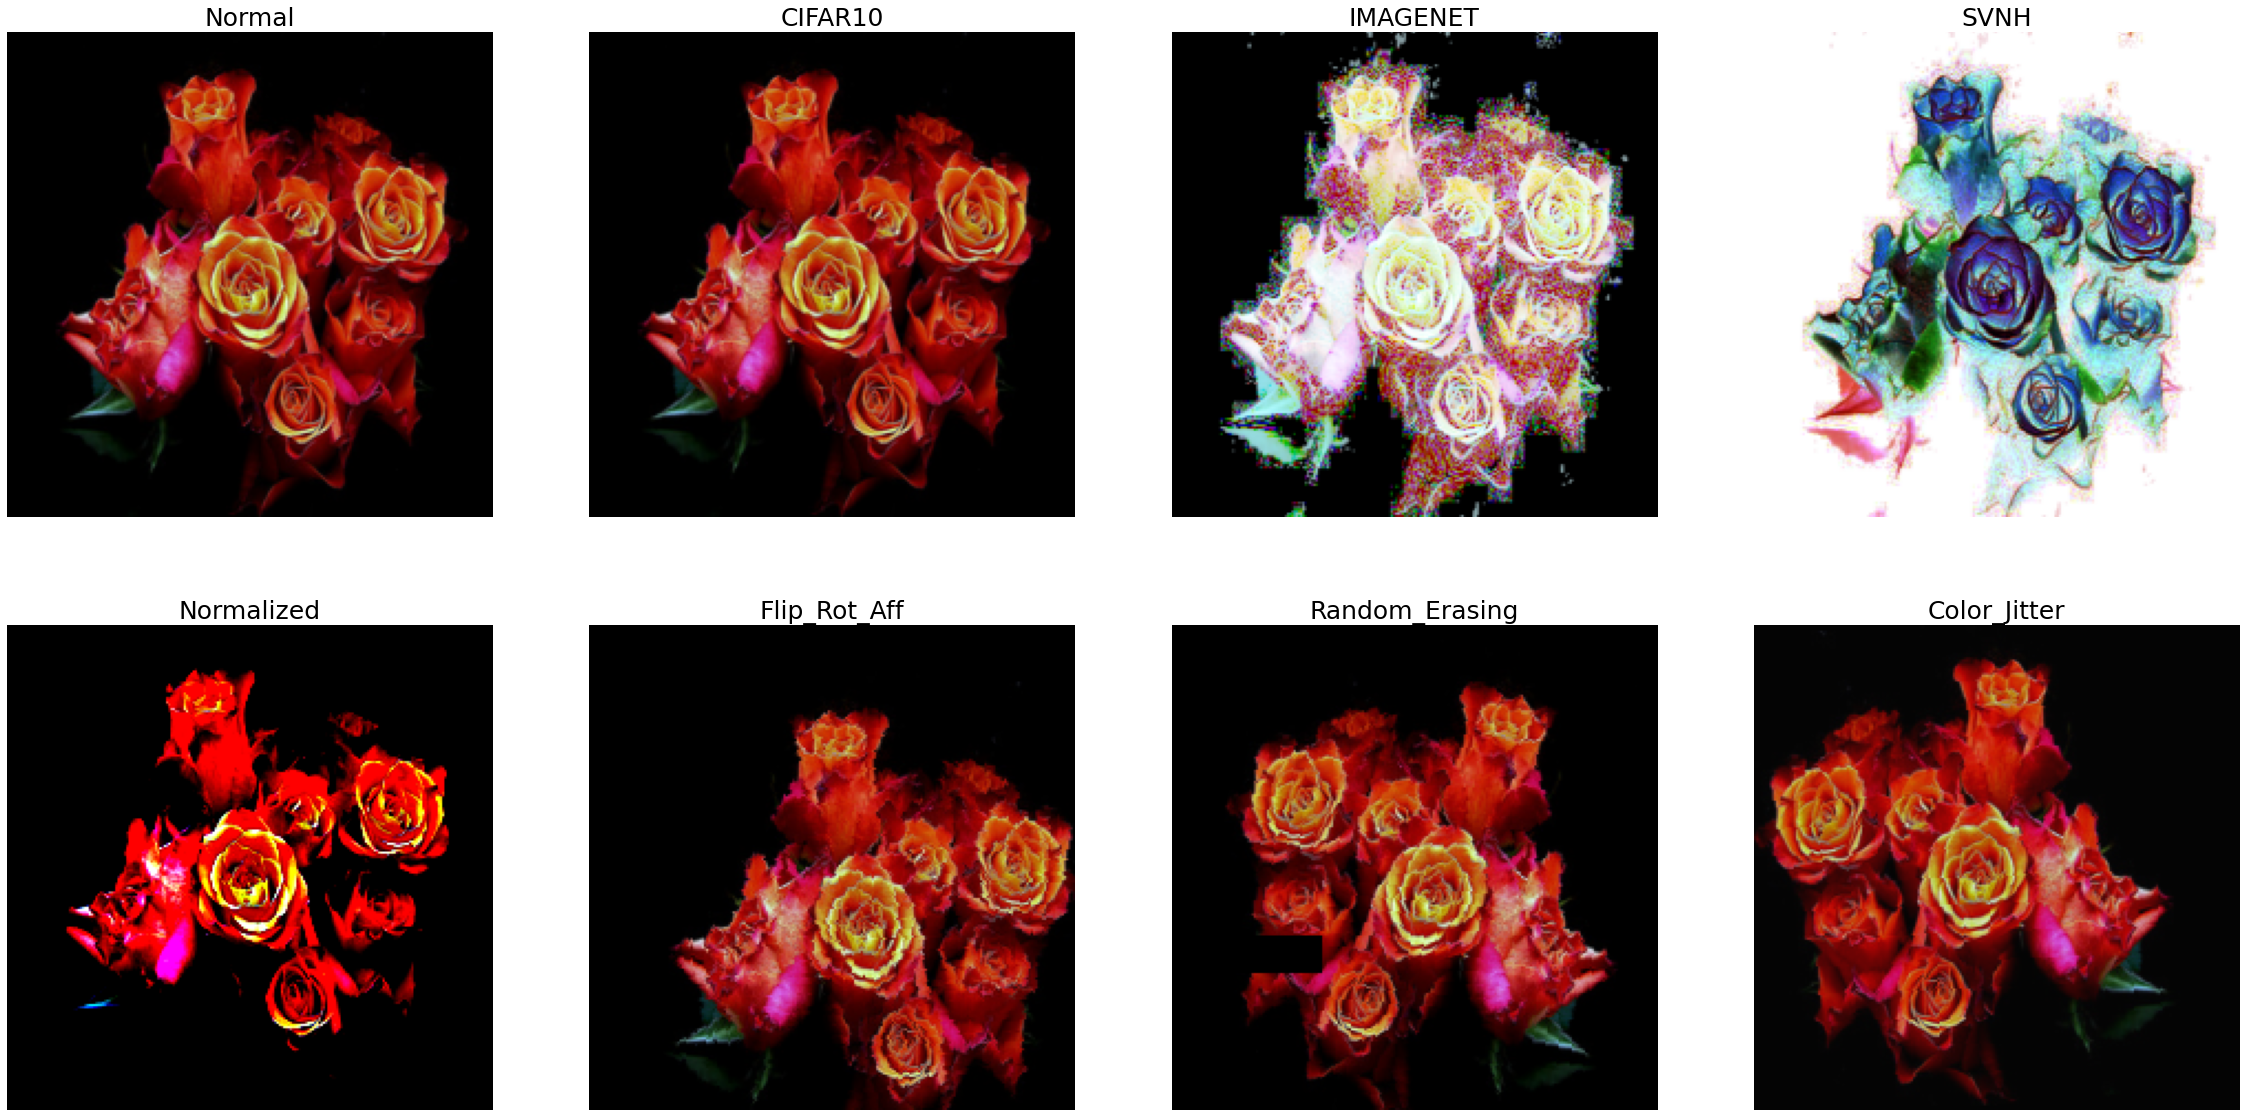

In [27]:
#Read image
img, label = dataset['raw'][1337]
img0, label0 = dataset['normalized'][1337]
img1, label1 = dataset['CIFAR10'][1337]
img2, label2 = dataset['IMAGENET'][1337]
img3, label3 = dataset['SVHN'][1337]
img4, label4 = dataset['Flip_Rot_Aff'][1337]
img5, label5 = dataset['Random_Erasing'][1337]
img6, label6 = dataset['Color_Jitter'][1337]

#Apply permuation for the channels
img = np.array(img).transpose(1,2,0)
img0 = np.array(img0).transpose(1,2,0)
img1 = np.array(img1).transpose(1,2,0)
img2 = np.array(img2).transpose(1,2,0)
img3 = np.array(img3).transpose(1,2,0)
img4 = np.array(img4).transpose(1,2,0)
img5 = np.array(img5).transpose(1,2,0)
img6 = np.array(img6).transpose(1,2,0)

#Plot the images
fig, axarr = plt.subplots(2,4)

axarr[0][0].imshow(img)
axarr[0][0].axis('off')
axarr[0][0].set_title('Normal', fontsize=25)

axarr[0][1].imshow(img1)
axarr[0][1].axis('off')
axarr[0][1].set_title('CIFAR10', fontsize=25)

axarr[0][2].imshow(img2)
axarr[0][2].axis('off')
axarr[0][2].set_title('IMAGENET', fontsize=25)

axarr[0][3].imshow(img3)
axarr[0][3].axis('off')
axarr[0][3].set_title('SVNH', fontsize=25)

axarr[1][0].imshow(img0)
axarr[1][0].axis('off')
axarr[1][0].set_title('Normalized', fontsize=25)

axarr[1][1].imshow(img4)
axarr[1][1].axis('off')
axarr[1][1].set_title('Flip_Rot_Aff', fontsize=25)

axarr[1][2].imshow(img5)
axarr[1][2].axis('off')
axarr[1][2].set_title('Random_Erasing', fontsize=25)

axarr[1][3].imshow(img6)
axarr[1][3].axis('off')
axarr[1][3].set_title('Color_Jitter', fontsize=25)

#Save the image
plt.savefig(os.path.join(path_plots,"all_augmentations"))

### CNNs Performance

In order to always produce the same results. The group decided to perform one time the division of the dataset into training, validation and testing. Furthermore, the transformations are then applied and saved. Here we only import the training data with all the augmentations, the validation data and the testing data. 

By doing this, the data used to train, validate and test is always the same, and therefore, the results are always constant.

The file where this is done is named as "data_preparation.ipynb"

Furthermore, in order to not overwhelm the code here with model training, all the models were trained in the file "training_CNN.ipynb".
The models are imported in the code below.

In [18]:
def ImportModel(layers,name):
    #Importing model backbone
    if layers == '18':
        model = torchvision.models.resnet18()
    elif layers == '101':
        model = torchvision.models.resnet101()
    else:
        print("No defined model")
        exit

    #Changing last layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5, bias=True)
    #Updating the weights and bias
    model.load_state_dict(torch.load(os.path.join(path_models, name)))
    model = model.to(device)
    model.eval()
    return model



#Importing the test data and normalizing it
test_set= ImageFolder(path_test, transform=transformations['raw'])
test_set_norm = ImageFolder(path_test, transform=transformations['normalized'])

## Importing the models

#ResNet18 trained with normalized data with Transfer Learning
resnet18 = ImportModel('18','ResNet_18_norm')

#ResNet18 trained with no image transformations (not even normalization) and with Transfer Learning
resnet18_no_norm = ImportModel('18','ResNet_18_no_aug')

#ResNet18 trained with data from the train_aug folder and with Transfer Learning
resnet18_aug = ImportModel('18','ResNet_18_norm_aug')

#ResNet18 trained with data from the train_simple_aug folder and with Transfer Learning
resnet18_simple_aug = ImportModel('18','ResNet_18_simple_aug')

#ResNet18 trained with data from the train_one_aug folder and with Transfer Learning
resnet18_one_aug = ImportModel('18','ResNet_18_one_aug')

#ResNet101
#ResNet101 trained with normalized data and with Transfer Learning
resnet101 = ImportModel('101','ResNet_101_no_aug')

#ResNet101 trained with data from the train_aug folder and with Transfer Learning
resnet101_norm_aug = ImportModel('101','ResNet_101_norm_aug')

#ResNet101 trained with data from the train_one_aug folder and with Transfer Learning
resnet101_one_aug = ImportModel('101','ResNet_101_one_aug')

#Define List with all the models
trained_models = [resnet18, resnet18_no_norm, resnet18_aug, resnet18_simple_aug, resnet18_one_aug, resnet101, resnet101_norm_aug, resnet101_one_aug]
name_models = ['resnet18', 'resnet18_no_norm', 'resnet18_aug', 'resnet18_simple_aug', 'resnet18_one_aug', 'resnet101', 'resnet101_norm_aug', 'resnet101_one_aug']

"trained_models = [resnet18_no_tf, resnet18, resnet18_no_norm, resnet18_aug, resnet18_less_aug, resnet18_simple_aug, resnet18_one_aug, resnet101, resnet101_norm_aug, resnet101_less_aug, resnet101_one_aug]\nname_models = ['resnet18_no_tf', 'resnet18', 'resnet18_no_norm', 'resnet18_aug', 'resnet18_less_aug', 'resnet18_simple_aug', 'resnet18_one_aug', 'resnet101', 'resnet101_norm_aug', 'resnet101_less_aug', 'resnet101_one_aug']"

Define the "check accuracy" function in order to evaluate the obtained models in the test set

In [20]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    return num_correct/num_samples * 100 

Define the loaders to input the data being tested

In [21]:
bs = 32
nw = 4

test_loader = DataLoader(test_set, batch_size=bs, num_workers=nw, pin_memory=True)

test_norm_loader = DataLoader(test_set_norm, batch_size=bs, num_workers=nw, pin_memory=True)

Test the models

In [24]:
for i, model in enumerate(trained_models):
    #In case the model was trained without normalized data the test set is also not normalized. This only happens in one model of resnet18
    if name_models[i] == 'resnet18_no_norm' or name_models[i] == 'resnet101':
        test_accuracy = check_accuracy(test_loader, model)
        print(name_models[i] + " Performance in Test Set : {:.2f}%".format(test_accuracy.item()))
    
    else:
        test_accuracy = check_accuracy(test_norm_loader, model)
        print(name_models[i] + " Performance in Test Set : {:.2f}%".format(test_accuracy.item()))

100%|██████████| 28/28 [00:04<00:00,  6.90it/s]


resnet18 Performance in Test Set : 90.67%


100%|██████████| 28/28 [00:03<00:00,  7.19it/s]


resnet18_no_norm Performance in Test Set : 90.55%


100%|██████████| 28/28 [00:04<00:00,  6.86it/s]


resnet18_aug Performance in Test Set : 85.25%


100%|██████████| 28/28 [00:04<00:00,  6.66it/s]


resnet18_simple_aug Performance in Test Set : 71.77%


100%|██████████| 28/28 [00:04<00:00,  6.17it/s]


resnet18_one_aug Performance in Test Set : 89.29%


100%|██████████| 28/28 [00:06<00:00,  4.53it/s]


resnet101 Performance in Test Set : 88.13%


100%|██████████| 28/28 [00:06<00:00,  4.55it/s]


resnet101_norm_aug Performance in Test Set : 72.47%


100%|██████████| 28/28 [00:06<00:00,  4.52it/s]

resnet101_one_aug Performance in Test Set : 87.67%


Confusion Matrix of the ResNet101 with One Augmentation and Transfer Learning

<Figure size 432x288 with 0 Axes>

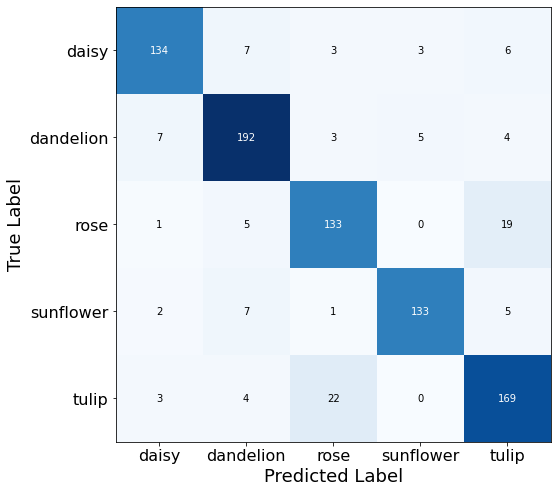

In [8]:
from mlxtend.plotting import plot_confusion_matrix

y_pred = []
y_test = []

for inputs, labels in test_norm_loader:
    inputs = inputs
    labels = labels

    outputs = resnet101_one_aug(inputs)
    _, preds = torch.max(outputs, 1)

    for prediction in preds:
        y_pred.append(prediction.item())
    for label in labels:
        y_test.append(label.item())

cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(len(categories)), categories, fontsize=16)
plt.yticks(range(len(categories)), categories, fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

#Save the image
plt.savefig(os.path.join(path_plots,"resnet101_one_aug_confusion_matrix"))